# Modeling

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
import seaborn as sns
import surprise
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import cross_validate
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)

In [2]:
# data

cols = ["user_id", "movie_id", "rating", "timestamp"]
ratings = pd.read_csv(
    os.path.join("../data", "ml-100k", "u.data"),
    sep="\t",
    names=cols,
    encoding="latin-1",
)

ratings
ratings = ratings.drop(columns=["timestamp"])
ratings.head()

# Movies data

cols = [
    "movie_id",
    "movie_title",
    "release_date",
    "video_release_date",
    "IMDb_URL",
    "unknown",
    "Action",
    "Adventure",
    "Animation",
    "Children",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]

movies_data = pd.read_csv(
    os.path.join("../data", "ml-100k", "u.item"),
    sep="|",
    names=cols,
    encoding="latin-1",
)


movie_titles = movies_data[['movie_id', 'movie_title']]
# Description of the data

user_key = "user_id"
item_key = "movie_id"

N = len(np.unique(ratings[user_key]))
M = len(np.unique(ratings[item_key]))

In [3]:
X = ratings.copy()
y = ratings["user_id"]
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Mapper to train Map ratings

user_mapper = dict(zip(np.unique(ratings[user_key]), list(range(N))))
item_mapper = dict(zip(np.unique(ratings[item_key]), list(range(M))))
user_inverse_mapper = dict(zip(list(range(N)), np.unique(ratings[user_key])))
item_inverse_mapper = dict(zip(list(range(M)), np.unique(ratings[item_key])))


train_mat = None
valid_mat = None

In [4]:
def create_Y_from_ratings(data, N, M):
    '''
    Create ranking matrix

    '''
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        Y[n, m] = val["rating"]

    return Y

In [5]:
train_mat = create_Y_from_ratings(X_train, N, M)
valid_mat = create_Y_from_ratings(X_valid, N, M)

print("train_mat shape: ", train_mat.shape)
print("valid_mat shape: ", valid_mat.shape)

train_mat shape:  (943, 1682)
valid_mat shape:  (943, 1682)


In [6]:
train_mat

array([[nan,  3.,  4., ..., nan, nan, nan],
       [ 4., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 5., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan,  5., nan, ..., nan, nan, nan]])

In [7]:
print("Number of non-nan elements in train_mat: ", np.sum(~np.isnan(train_mat))/(943*1682))
print("Number of non-nan elements in valid_mat: ", np.sum(~np.isnan(valid_mat)))

Number of non-nan elements in train_mat:  0.05043735491379626
Number of non-nan elements in valid_mat:  20000


In [8]:
def error(Y1, Y2):
    """
    Returns the root mean squared error (RMSE).
    """
    return np.sqrt(np.nanmean((Y1 - Y2) ** 2))


def evaluate(pred_Y, train_mat, valid_mat, model_name="Global average"):
    print("%s train RMSE: %0.2f" % (model_name, error(pred_Y, train_mat)))
    print("%s valid RMSE: %0.2f" % (model_name, error(pred_Y, valid_mat)))

In [9]:
#Base line model

avg = np.nanmean(train_mat)
pred_g = np.zeros(train_mat.shape) + avg
evaluate(pred_g, train_mat, valid_mat, model_name="Global average")

Global average train RMSE: 1.13
Global average valid RMSE: 1.12


In [10]:
results = {'Components' : [],
          'RMSE': []}

### Hyperparameter optimization

In [11]:
# Matrix Factorization and regularization

reader = Reader()
data = Dataset.load_from_df(ratings, reader)

results = {'Components' : [],
          'Mean RMSE': []}

for n in range(5 , 30, 5):
    model_svd = SVD(n_factors=n, random_state=42)
    mean_rmse = round(pd.DataFrame(cross_validate(model_svd, data, measures=['RMSE'], cv=5, verbose=False))['test_rmse'].mean(),3)
    results['Components'].append(n)
    results['Mean RMSE'].append(mean_rmse)
    print(f"Surprise SVD {n} components Mean RMSE {mean_rmse}")

Surprise SVD 5 components Mean RMSE 0.938
Surprise SVD 10 components Mean RMSE 0.938
Surprise SVD 15 components Mean RMSE 0.936
Surprise SVD 20 components Mean RMSE 0.935
Surprise SVD 25 components Mean RMSE 0.937


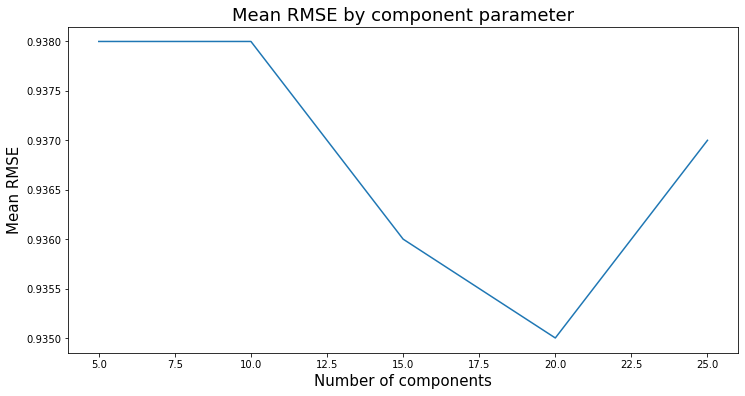

In [12]:
results_df = pd.DataFrame(results)

plt.figure(figsize=(12,6))
plt.plot(results_df['Components'], results_df['Mean RMSE'])
plt.title('Mean RMSE by component parameter', fontsize=18)
plt.xlabel('Number of components', fontsize=15)
plt.ylabel('Mean RMSE', fontsize=15)
plt.show()

In [17]:
trainset, validset = surprise.model_selection.train_test_split(
    data, test_size=0.2, random_state=42
)

k = 20
algo = SVD(n_factors=k, random_state=42)
algo.fit(trainset)
svd_preds = algo.test(validset)
print(f"RMSE score for k={k} factors: {accuracy.rmse(svd_preds, verbose=False):.2f}")

RMSE score for k=20 factors: 0.93


### Recommendation Outputs

In [18]:
# Code inspired by Nicolas Hug recommedation systems

from collections import defaultdict


def top_n_recs(user_id, n=5):
    '''
    Function that returns the top n transaction for each user_id 
    '''
    top_n = get_top_n(svd_preds, n=n)
    data_temp =pd.DataFrame(top_n[user_id], columns=["movie_id", "pred"])
    return pd.merge(data_temp, movie_titles, right_on='movie_id', left_on='movie_id', how='left')[['movie_title', 'pred']]


def get_top_n(predictions, n=10):
    """
    Return the top-N recommendation for each user from a set of predictions of the SVD model

    """
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [19]:
size = 3
u_id_sample = ratings["user_id"].sample(size).to_list()
u_id_sample

[774, 398, 87]

In [20]:
n = 5
for user_id in u_id_sample:
    print("\nTop %d recommendations for user with id : %d" % (n, user_id))
    df = top_n_recs(user_id, n=n)
    df['pred'] = df['pred'].round(decimals = 2)
    print(df)


Top 5 recommendations for user with id : 774
                        movie_title  pred
0               12 Angry Men (1957)  3.30
1  Shawshank Redemption, The (1994)  2.87
2      2001: A Space Odyssey (1968)  2.78
3                 Braveheart (1995)  2.77
4                     Psycho (1960)  2.75

Top 5 recommendations for user with id : 398
                      movie_title  pred
0              Rear Window (1954)  4.25
1             Citizen Kane (1941)  4.24
2      Princess Bride, The (1987)  4.23
3                Star Wars (1977)  4.19
4  Raiders of the Lost Ark (1981)  4.18

Top 5 recommendations for user with id : 87
                        movie_title  pred
0  Shawshank Redemption, The (1994)  4.88
1           Schindler's List (1993)  4.83
2                      Glory (1989)  4.59
3         Return of the Jedi (1983)  4.57
4          Strictly Ballroom (1992)  4.53
